# 12장. 다층 인공 신경망을 밑바닥부터 구현

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/python-machine-learning-book-2nd-edition/blob/master/code/ch12/ch12.ipynb"><img src="https://jupyter.org/assets/main-logo.svg" width="28" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-2nd-edition/blob/master/code/ch12/ch12.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

`watermark`는 주피터 노트북에 사용하는 파이썬 패키지를 출력하기 위한 유틸리티입니다. `watermark` 패키지를 설치하려면 다음 셀의 주석을 제거한 뒤 실행하세요.

In [ ]:
#!pip install watermark

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,scipy,matplotlib

last updated: 2019-04-26 

CPython 3.7.3
IPython 7.4.0

numpy 1.16.3
scipy 1.2.1
matplotlib 3.0.3


## 12.1 인공 신경망으로 복잡한 함수 모델링
- 인공신경망 : 사람의 뇌가 어떻게 복잡한 문제를 푸는지에 대한 가설과 모델을 기반
    1. 인간 두뇌에서 일어나는 반응결정체계를 자연계 현상의 예측 과정에 도입한 알고리즘
    2. 모형식의 형태를 알 수 없거나, 비선형 모형의 예측의 과정이 매우 복잡한 경우에 적용
    3. 과거의 입력값과 출력값을 알고있는 경우 새로운 입력값들에 대한 출력값을 추정하는데 유용
- 워렌 매컬록, 월터 피츠가 다수의 뉴련으로부터 신호를 받은 뉴런은 시냅스 결합의 강도에 따른 자극을 받아들어 자극의 총합이 역치를 넘으면 흥분한 것으로 나타내도록 모형화함 (1940년대)
- 맥컬록-피츠는 뉴런 모델인 로젠블라트 퍼셉트론(패턴인식을 학습하는 신경회로망 모델) 구현 (1950년대)
- Nakano는 신경회로망 연상기억용 모형인 어소시아트론(몇 가지 패턴을 기억시킨 후 그 중 일부를 입력으로 주면 전체를 기억해 내는 기능)을 제안 (1969)
- Hopfield는 신경회로망을 연상기억과 최적해를 구하는 문제에 활용할 수 있다고 제안 (1980)
- 루멜하트, 힌튼, 윌리엄스 역전파 알고리즘 (최급강하법을 이용) 재발견 (1986)

<신경회로망의 장단점>
- 장점 
    - 이론적으로 복잡하지 않으면서도 기계학습이 됨
- 단점
    - 최적해 구하는 문제에서 극소값으로 빠질 수 있다.
    - 은닉 층의 수나 노드의 수가 증가하면 계산시간이 급증한다.
    - 출력과 입력사이 인과관계에 대한 물리적 설명이 어렵다.
    
### 단일층 신경망 요약
- 아달린 알고리즘을 통한 예측 (선형 함수 사용)
- 경사 하강법 최적화 알고리즘을 사용하여 모델 가중치 학습
- 제곱 오차합 비용 함수로 정의된 목적 함수를 최적화 하여 최적 모델 가중치를 찾음
- 비용 함수의 전역 최솟값을 지나치지 않도록 학습 속도를 조절하기 위해 학습률을 그래디언트에 곱함
- 에포크마다 모든 가중치를 동시에 업데이트하여 입력층과 출력층을 연결하는 가중치의 선형 결합을 생성
- 예측을 위해서 임계 함수를 구현
- 모델 학습의 가속을 위해 확률적 경사 하강법 최적화 기법도 사용 가능

### 다층 신경망 구조
- 다층 퍼셉트론 : 여러 개의 단일 뉴런을 연결하여 다층 피드포워드 신경망을 만드는 법
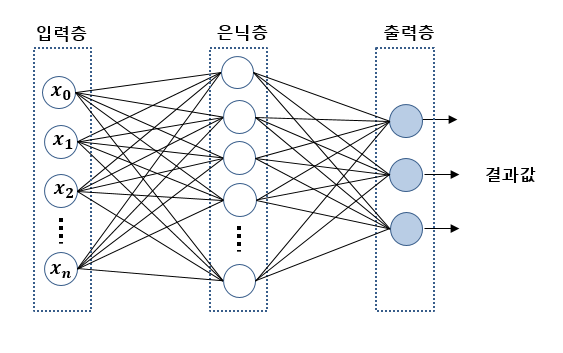
- 은닉층의 유닛은 입력층과 출력층은 은닉층과 완전 연결되어 있다.
- 하나 이상의 은닉 층을 가진 네트워크를 **심층 인공 신경망**이라 한다.
- 은닉 층의 노드들을 연결하는 가중치들의 물리적 의미를 부여하지 않아 은닉 층 부분은 black box 역할을 한다.
- 입력된 변수값들이 다음 은닉 층으로 전달하는 과정과 노드에 저장되는 과정에서 함수의 선택이 중요하다.
- 알고리즘의 구성은 신경 회로망의 출력값과 추정값의 차이가 최소가 되도록 가중치들을 변화시키는 역전파법이 중심이 된다.
- 가중치의 변화량의 크기결정에 유의하여야한다.


- 정보전달함수 : 여러 노드의 정보를 묶어 다음 단계로 전달해주는 역할
    - Linear Basis Function : 일차결합에 의한 정보전달함수로 많이 사용
    - Radial Basis Function : 거리 개념에 의한 정보전달 함수
    - Ellipic Basis Function : RBRF의 변형된 형태
- 정보활성화함수 : 정보전달함수에 의하여 전달된 자극을 노드에 저장하는 역할
    - 계단함수 
    - ramp 함수
    - 시그모이드 함수 : 늘어진 S자 형태, 단조증가, 미분가능인 유계함수(로지즈식 함수, tanh함수)
    - 가우시안 함수
    
### 정방향 계산으로 신경망 활성화 출력 계산
<MLP 학습 과정>
1. 입력층에서 시작해서 정방향으로 훈련 데이터의 패턴을 네트워크에 전파하여 출력을 만듦
2. 네트워크의 출력을 기반으로 나중에 설명할 비용 함수를 이용하여 최소화해야 할 오차 계산
3. 네트워크에 있는 모든 가중치에 대한 도함수를 찾아 오차를 역전파하고 모델을 업데이트한다.
4. 3단계를 여러 에포크 동안 반복하여 가중치를 학습 (**최적 가중치를 결정하는 학습 과정**)
5. 클래스 레이블 예측을 위해 정방향 계산으로 네트워크의 출력을 만들고 임계함수를 적용 (**새로운 입력 자료에 대한 출력 추정값을 구하는 인식 과정**)


MLP는 대표적인 피드포워드 인공 신경망
(피드포워드 : 각 층에서 입력을 순환시키지 않고 다음 층으로 전달)

## 12.2 손글씨 숫자 분류하기

## MNIST 데이터셋 구하기

MNIST 데이터셋은 http://yann.lecun.com/exdb/mnist/에 공개되어 있으며 다음 네 부분으로 구성되어 있습니다.

- 훈련 세트 이미지: train-images-idx3-ubyte.gz(9.9MB, 압축 해제 후 47MB, 60,000개 샘플)
- 훈련 세트 레이블: train-labels-idx1-ubyte.gz(29KB, 압축 해제 후 60KB, 60,000개 레이블)
- 테스트 세트 이미지: t10k-images-idx3-ubyte.gz(1.6MB, 압축 해제 후 7.8MB, 10,000개 샘플)
- 테스트 세트 레이블: t10k-labels-idx1-ubyte.gz(5KB, 압축 해제 후 10KB, 10,000개 레이블)

파일을 다운로드한 후에 다음 코드 셀을 실행하면 파일 압축을 풀 수 있습니다.

**코랩을 사용할 때는 다음 셀의 주석을 제거하고 실행하세요.**

In [ ]:
#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/t10k-images-idx3-ubyte.gz
#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/t10k-labels-idx1-ubyte.gz
#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/train-images-idx3-ubyte.gz
#!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/train-labels-idx1-ubyte.gz  

In [2]:
# MNIST 데이터 압축을 푸는 코드

import sys
import gzip
import shutil
import os

if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir('./') if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read()) 

In [3]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """`path`에서 MNIST 데이터 불러오기"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)
        
        # > : 빅 엔디언(바이트가 저장된 순서)
        # I : 부호 없는 정수

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2 # -1에서 1사이로 정규화
 
    return images, labels

In [20]:
!ls

README.md		t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
ch12.ipynb		t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
mnist_scaled.npz	t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz
t10k-images-idx3-ubyte	train-images-idx3-ubyte


In [5]:
# 데이터 로드
X_train, y_train = load_mnist('', kind='train')
print('행: %d, 열: %d' % (X_train.shape[0], X_train.shape[1]))

행: 60000, 열: 784


In [6]:
X_test, y_test = load_mnist('', kind='t10k')
print('행: %d, 열: %d' % (X_test.shape[0], X_test.shape[1]))

행: 10000, 열: 784


각 클래스의 첫 번째 이미지를 그립니다:

In [7]:
import matplotlib.pyplot as plt

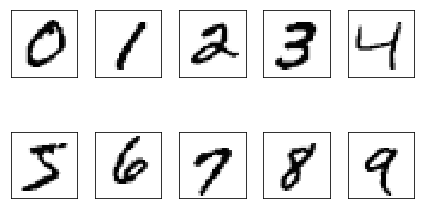

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28) # 28*28으로 크기 변경
    ax[i].imshow(img, cmap='Greys') # 이미지 그리기

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

숫자 7 샘플 25개를 그립니다:

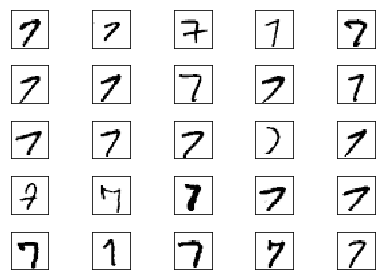

In [9]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

스케일 된 이미지를 새로운 파이썬 세션에서 빠르게 읽을 수 있는 포맷으로 저장하면 데이터를 일고 전처리하는 오버헤드를 피할 수 있다.

넘파이 배열을 사용할 때 다차원 배열을 디스크에 저장하는 효율적이고 가장 간편한 방법은 savez 함수를 사용하는 것이다. savez_compressed은 파일크기를 더 작게 압축한다.

In [10]:
import numpy as np

np.savez_compressed('mnist_scaled.npz', 
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)

In [11]:
# 전처리된 MNIST 이미지 배열을 로드
mnist = np.load('mnist_scaled.npz')
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [12]:
# 데이터 배열을 변수에 할당
X_train, y_train, X_test, y_test = [mnist[f] for f in ['X_train', 'y_train', 
                                    'X_test', 'y_test']]

del mnist

X_train.shape

(60000, 784)

### 다층 퍼셉트론 구현

In [13]:
import numpy as np
import sys


class NeuralNetMLP(object):
    """피드포워드 신경망 / 다층 퍼셉트론 분류기

    매개변수

    ------------
    n_hidden : int (기본값: 30)
        은닉 유닛 개수
    l2 : float (기본값: 0.)
        L2 규제의 람다 값
        l2=0이면 규제 없음. (기본값)
    epochs : int (기본값: 100)
        훈련 세트를 반복할 횟수
    eta : float (기본값: 0.001)
        학습률
    shuffle : bool (기본값: True)
        에포크마다 훈련 세트를 섞을지 여부
        True이면 데이터를 섞어 순서를 바꿉니다
    minibatch_size : int (기본값: 1)
        미니 배치의 훈련 샘플 개수
    seed : int (기본값: None)
        가중치와 데이터 셔플링을 위한 난수 초깃값

    속성
    -----------
    eval_ : dict
      훈련 에포크마다 비용, 훈련 정확도, 검증 정확도를 수집하기 위한 딕셔너리

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """레이블을 원-핫 방식으로 인코딩합니다

        매개변수
        ------------
        y : 배열, 크기 = [n_samples]
            타깃 값.

        반환값
        -----------
        onehot : 배열, 크기 = (n_samples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """로지스틱 함수(시그모이드)를 계산합니다"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """정방향 계산을 수행합니다"""

        # 단계 1: 은닉층의 최종 입력
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # 단계 2: 은닉층의 활성화 출력
        a_h = self._sigmoid(z_h)

        # 단계 3: 출력층의 최종 입력
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # 단계 4: 출력층의 활성화 출력
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """비용 함수를 계산합니다

        매개변수
        ----------
        y_enc : 배열, 크기 = (n_samples, n_labels)
            원-핫 인코딩된 클래스 레이블
        output : 배열, 크기 = [n_samples, n_output_units]
            출력층의 활성화 출력 (정방향 계산)

        반환값
        ---------
        cost : float
            규제가 포함된 비용

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        # 다른 데이터셋에서는 극단적인 (0 또는 1에 가까운) 활성화 값이 나올 수 있습니다.
        # 파이썬과 넘파이의 수치 연산이 불안정하기 때문에 "ZeroDivisionError"가 발생할 수 있습니다.
        # 즉, log(0)을 평가하는 경우입니다.
        # 이 문제를 해결하기 위해 로그 함수에 전달되는 활성화 값에 작은 상수를 더합니다.
        #
        # 예를 들어:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        
        return cost

    def predict(self, X):
        """클래스 레이블을 예측합니다

        매개변수
        -----------
        X : 배열, 크기 = [n_samples, n_features]
            원본 특성의 입력층

        반환값:
        ----------
        y_pred : 배열, 크기 = [n_samples]
            예측된 클래스 레이블

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """훈련 데이터에서 가중치를 학습합니다

        매개변수
        -----------
        X_train : 배열, 크기 = [n_samples, n_features]
            원본 특성의 입력층
        y_train : 배열, 크기 = [n_samples]
            타깃 클래스 레이블
        X_valid : 배열, 크기 = [n_samples, n_features]
            훈련하는 동안 검증에 사용할 샘플 특성
        y_valid : 배열, 크기 = [n_samples]
            훈련하는 동안 검증에 사용할 샘플 레이블

        반환값:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # 가중치 초기화
        ########################

        # 입력층 -> 은닉층 사이의 가중치
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # 은닉층 -> 출력층 사이의 가중치
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # 출력 포맷을 위해
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # 훈련 에포크를 반복합니다
        for i in range(self.epochs):

            # 미니 배치로 반복합니다
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # 정방향 계산
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # 역전파
                ##################

                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]

                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                # 규제와 가중치 업데이트
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # 편향은 규제하지 않습니다
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # 편향은 규제하지 않습니다
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # 평가
            #############

            # 훈련하는 동안 에포크마다 평가합니다
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | 비용: %.2f '
                             '| 훈련/검증 정확도: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [14]:
n_epochs = 200

In [15]:
# 784-100-10 크기의 MLP
nn = NeuralNetMLP(n_hidden=100, # 은닉 유닛
                  l2=0.01, # 과대적합을 줄이기 위한 L2 규제의 lambda 파라미터
                  epochs=n_epochs, # 훈련 세트를 반복할 횟수
                  eta=0.0005, # 학습률
                  minibatch_size=100, # 확률적 경사 하강법에서 에포크마다 훈련 세트를 나눈 미니 배치에 들어갈 훈련 샘플 개수
                  # 전체 훈련 세트에서 그래디언트를 계산하지 않고 학습 속도를 높이기 위해 미니 배치마다 계산
                  shuffle=True, # 알고리즘 순환 고리에 갇히지 않도록 에포크를 시작하기 전에 훈련 세트를 섞을지 여부
                  seed=1) # 셔플과 가중치 초기화를 위한 난수 초깃값

nn.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

200/200 | 비용: 5065.78 | 훈련/검증 정확도: 99.28%/97.98%  

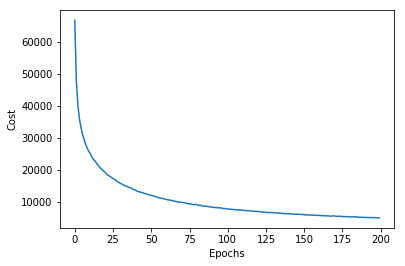

In [16]:
# MNIST 데이터셋에서 훈련한 다층 퍼셉트론의 비용 함수
import matplotlib.pyplot as plt

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

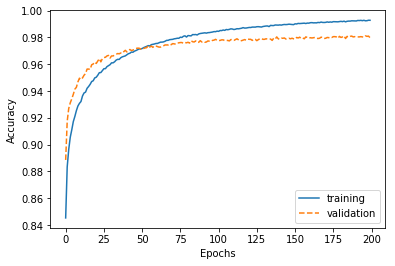

In [17]:
# MNIST 데이터셋에서 훈련한 다층 퍼셉트론의 정확도
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()
# 약 50번째 에포크에서 훈련 정확도와 검증 정확도 값이 동일하고 그 이후 네트워크는 훈련 세트에 과대적합되기 시작한다.

In [18]:
# 테스트 세트에서 예측 정확도를 계산하여 모델 일반화 성능 평가
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

print('테스트 정확도: %.2f%%' % (acc * 100))

테스트 정확도: 97.54%


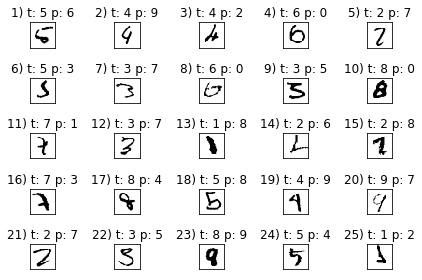

In [19]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## 12.3 인공 신경망 훈련 
### 로지스틱 비용 함수 계산
비용함수 <img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fb36a5W%2FbtqBE05AVxN%2Fpk5XUXQKNPdnyISJ7678Gk%2Fimg.png" height="50%" width="50%">
$$a^{[i]}=ϕ(z^{[i]})$$


L2 규제 항을 로지스틱 비용 함수에 추가하여 사용

일반화된 로지스틱 비용 함수 (규제 항 포함)

$J(W)=-[\sum_{i=1}^n \sum_{j=1}^t y_j^{[i]}log(a_j^{[i]})+(1-y_j^{[i]})log(1-a_j^{[i]})]$+$ λ\over{2}$ $ \sum_{l=1}^{L-1}$ $\sum_{i=1}^{u_l}$ $\sum_{j=1}^{u_l+1}$ $(w_{j,i}^{(l)})^2$

비용 함수 $J(W)$를 최소화 하기 위해 W의 편도 함수 계산 (역전파 알고리즘 사용)

하나의 은닉층을 가진 다층 퍼셉트론에는 $W^{(h)}$가 입력층과 은닉층을 연결하는 가중치 행렬, $W^{(out)}$이 은닉층과 출력층을 연결하는 가중치 행렬.


- 3차원 텐서<img src="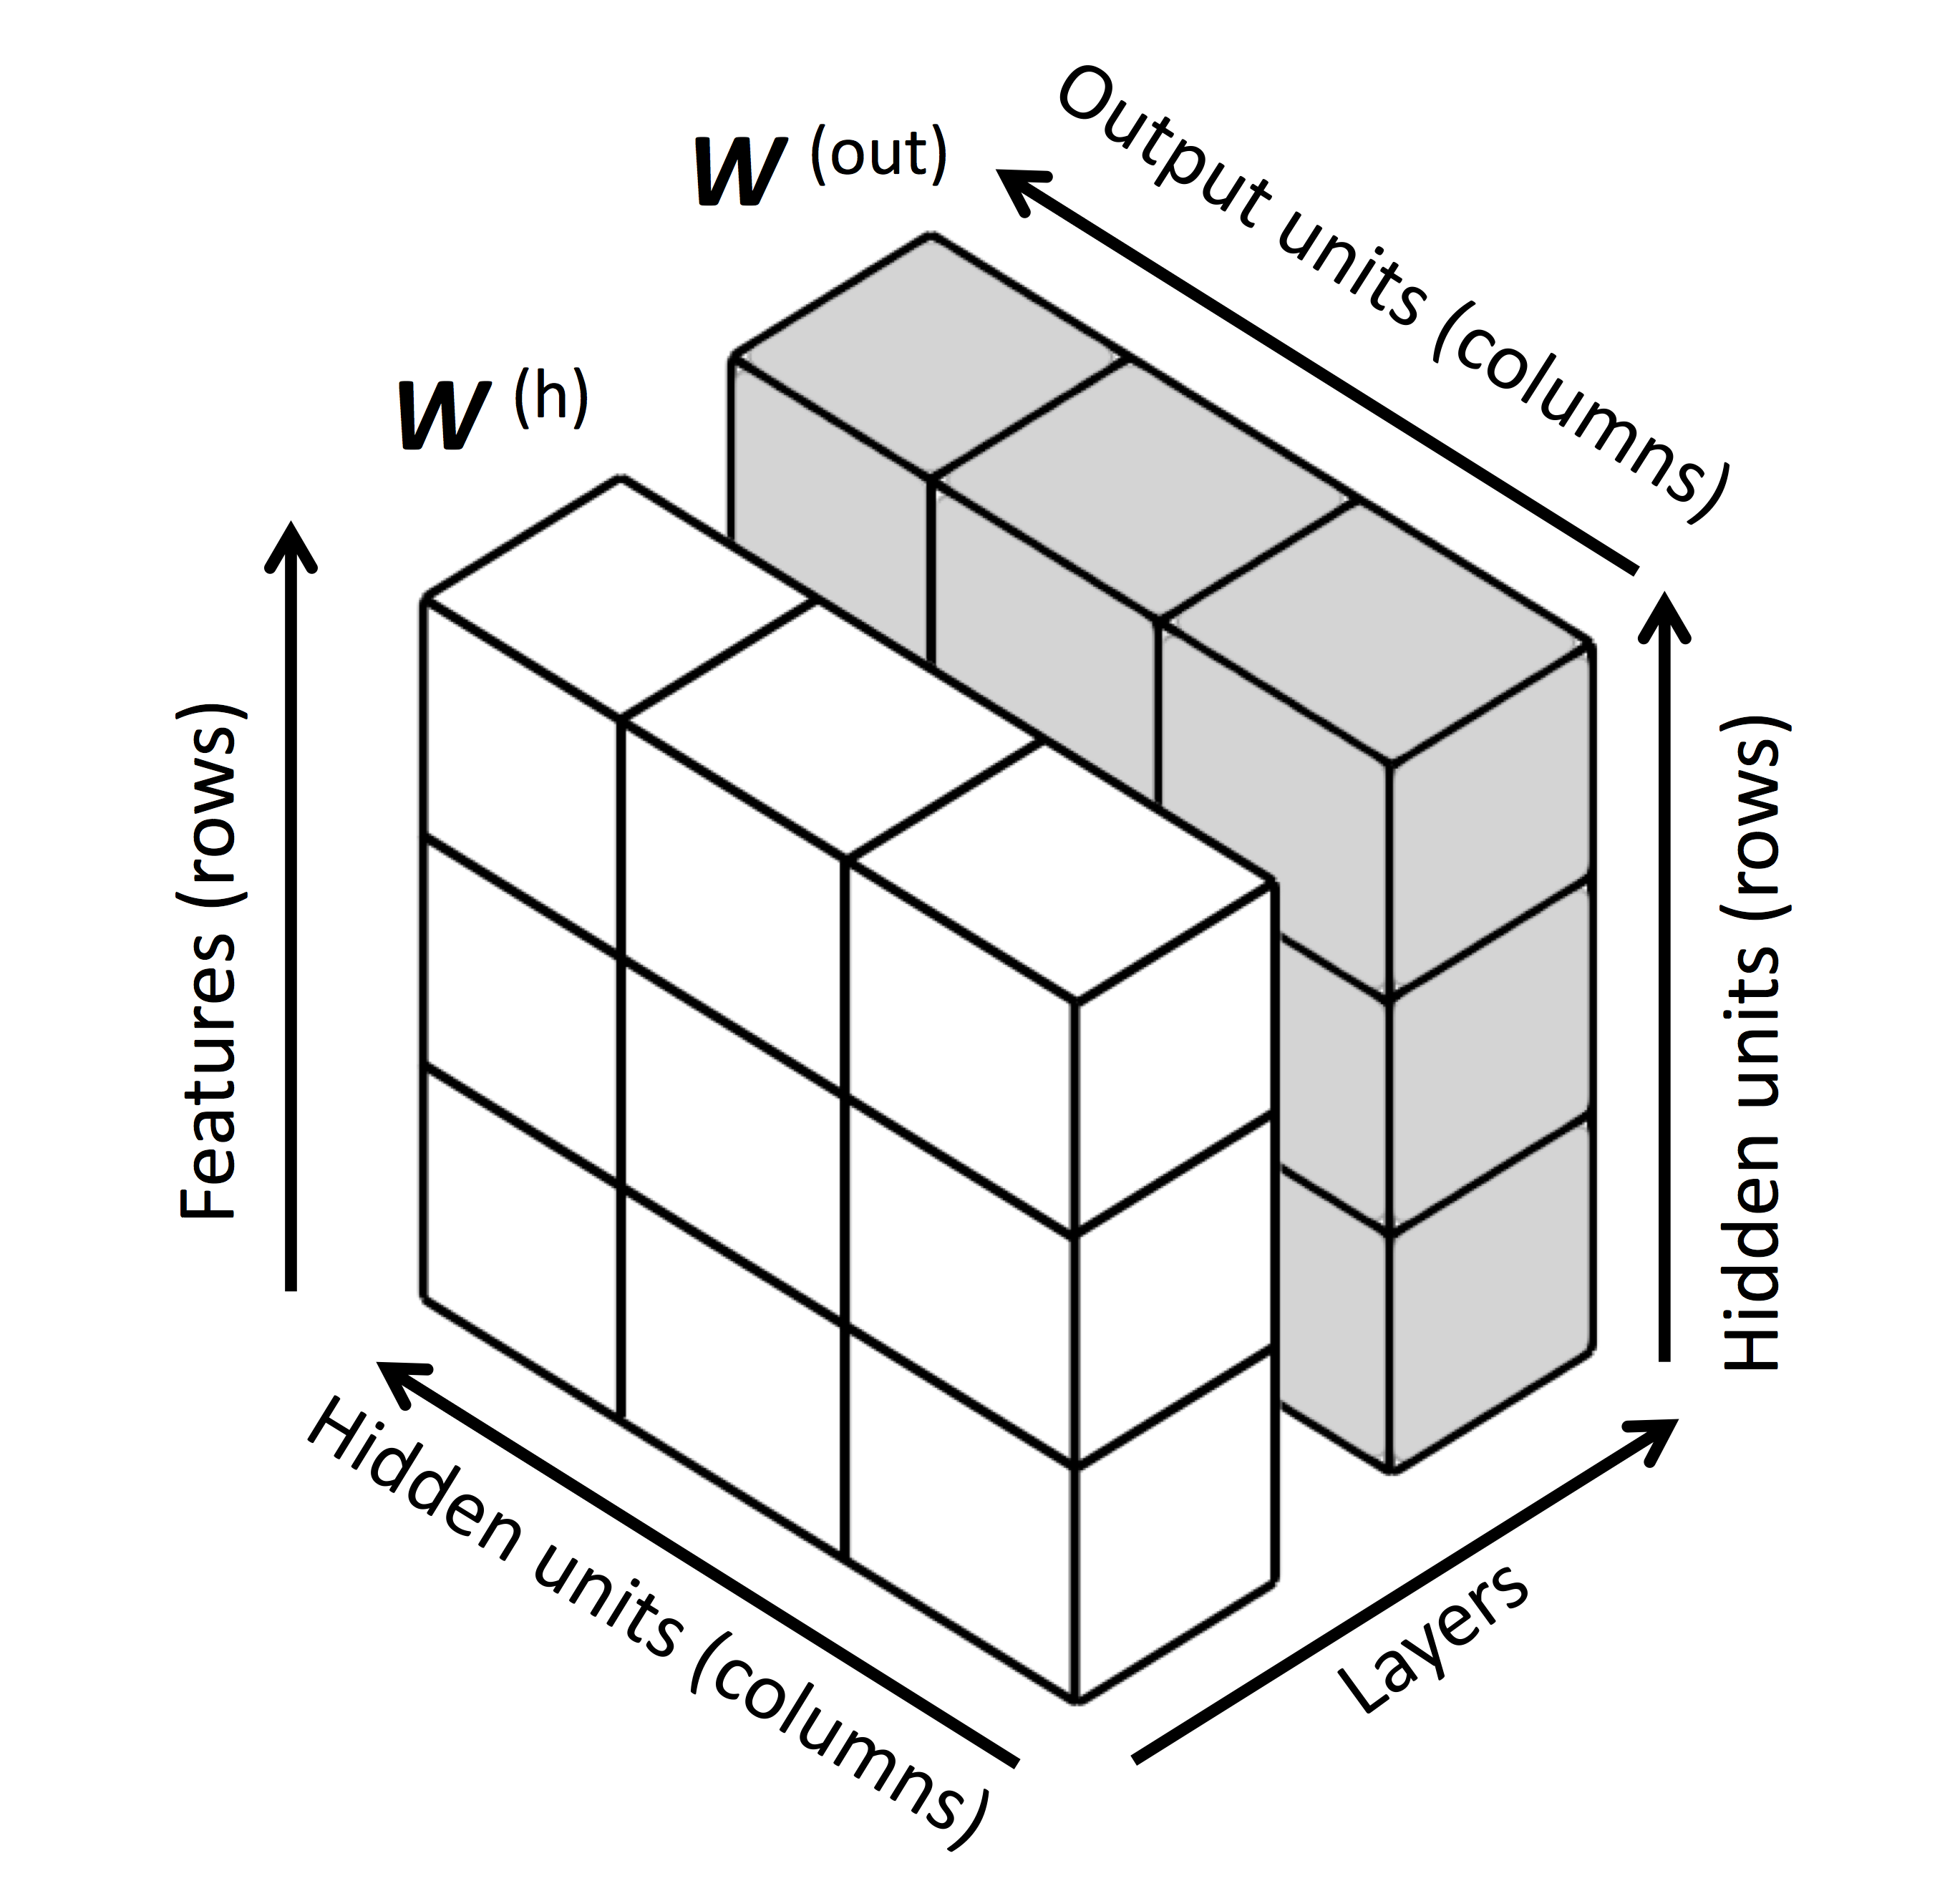%0A" height="30%" width="30%">

### 역전차 알고리즘 이해
- 역전파 알고리즘은 오차공간에서 출력오차를 최소로 하는 가중치 값을 찾는 기법으로 다층 신경망에서 복잡한 비용 함수의 편미분을 효율적으로 계산하기 위한 방법으로 생각할 수 있다.
- 편미분을 이용하여 다층 인공 신경망의 가중치 파라미터를 학습한다.

- 복잡하고 중첩된 함수의 도함수를 계산하는 방법인 연쇄 법칙을 계산하기 위한 방법으로 **자동 미분**을 사용 (컴퓨터 대수학)
- 자동미분은 정방향과 역방향 두 가지 모드가 있는데 역전파는 역방향 자동 미분의 특별한 경우이다.
- 역방향이 행렬-벡터 곱셈 후 벡터 출력 후 행렬-벡터 곱셈을 진행하여 행렬-행렬 곱셈을 하지 않는다. 그러므로 계산 비용이 적게들어서 인기 있는 알고리즘이 되었다.


- 순차적 학습 방법 : 입력 자료를 하나씩 읽어가며 역전파법에 의하여 가중치를 변화시킴
- 일괄 학습 방법 : 입력 자료를 전부 읽은 후 역전파법에 의하여 가중치를 한꺼번에 변화시킴(잘 안씀)

### 역전파 알고리즘으로 신경망 훈련
신경망의 정향향 계산
<img src="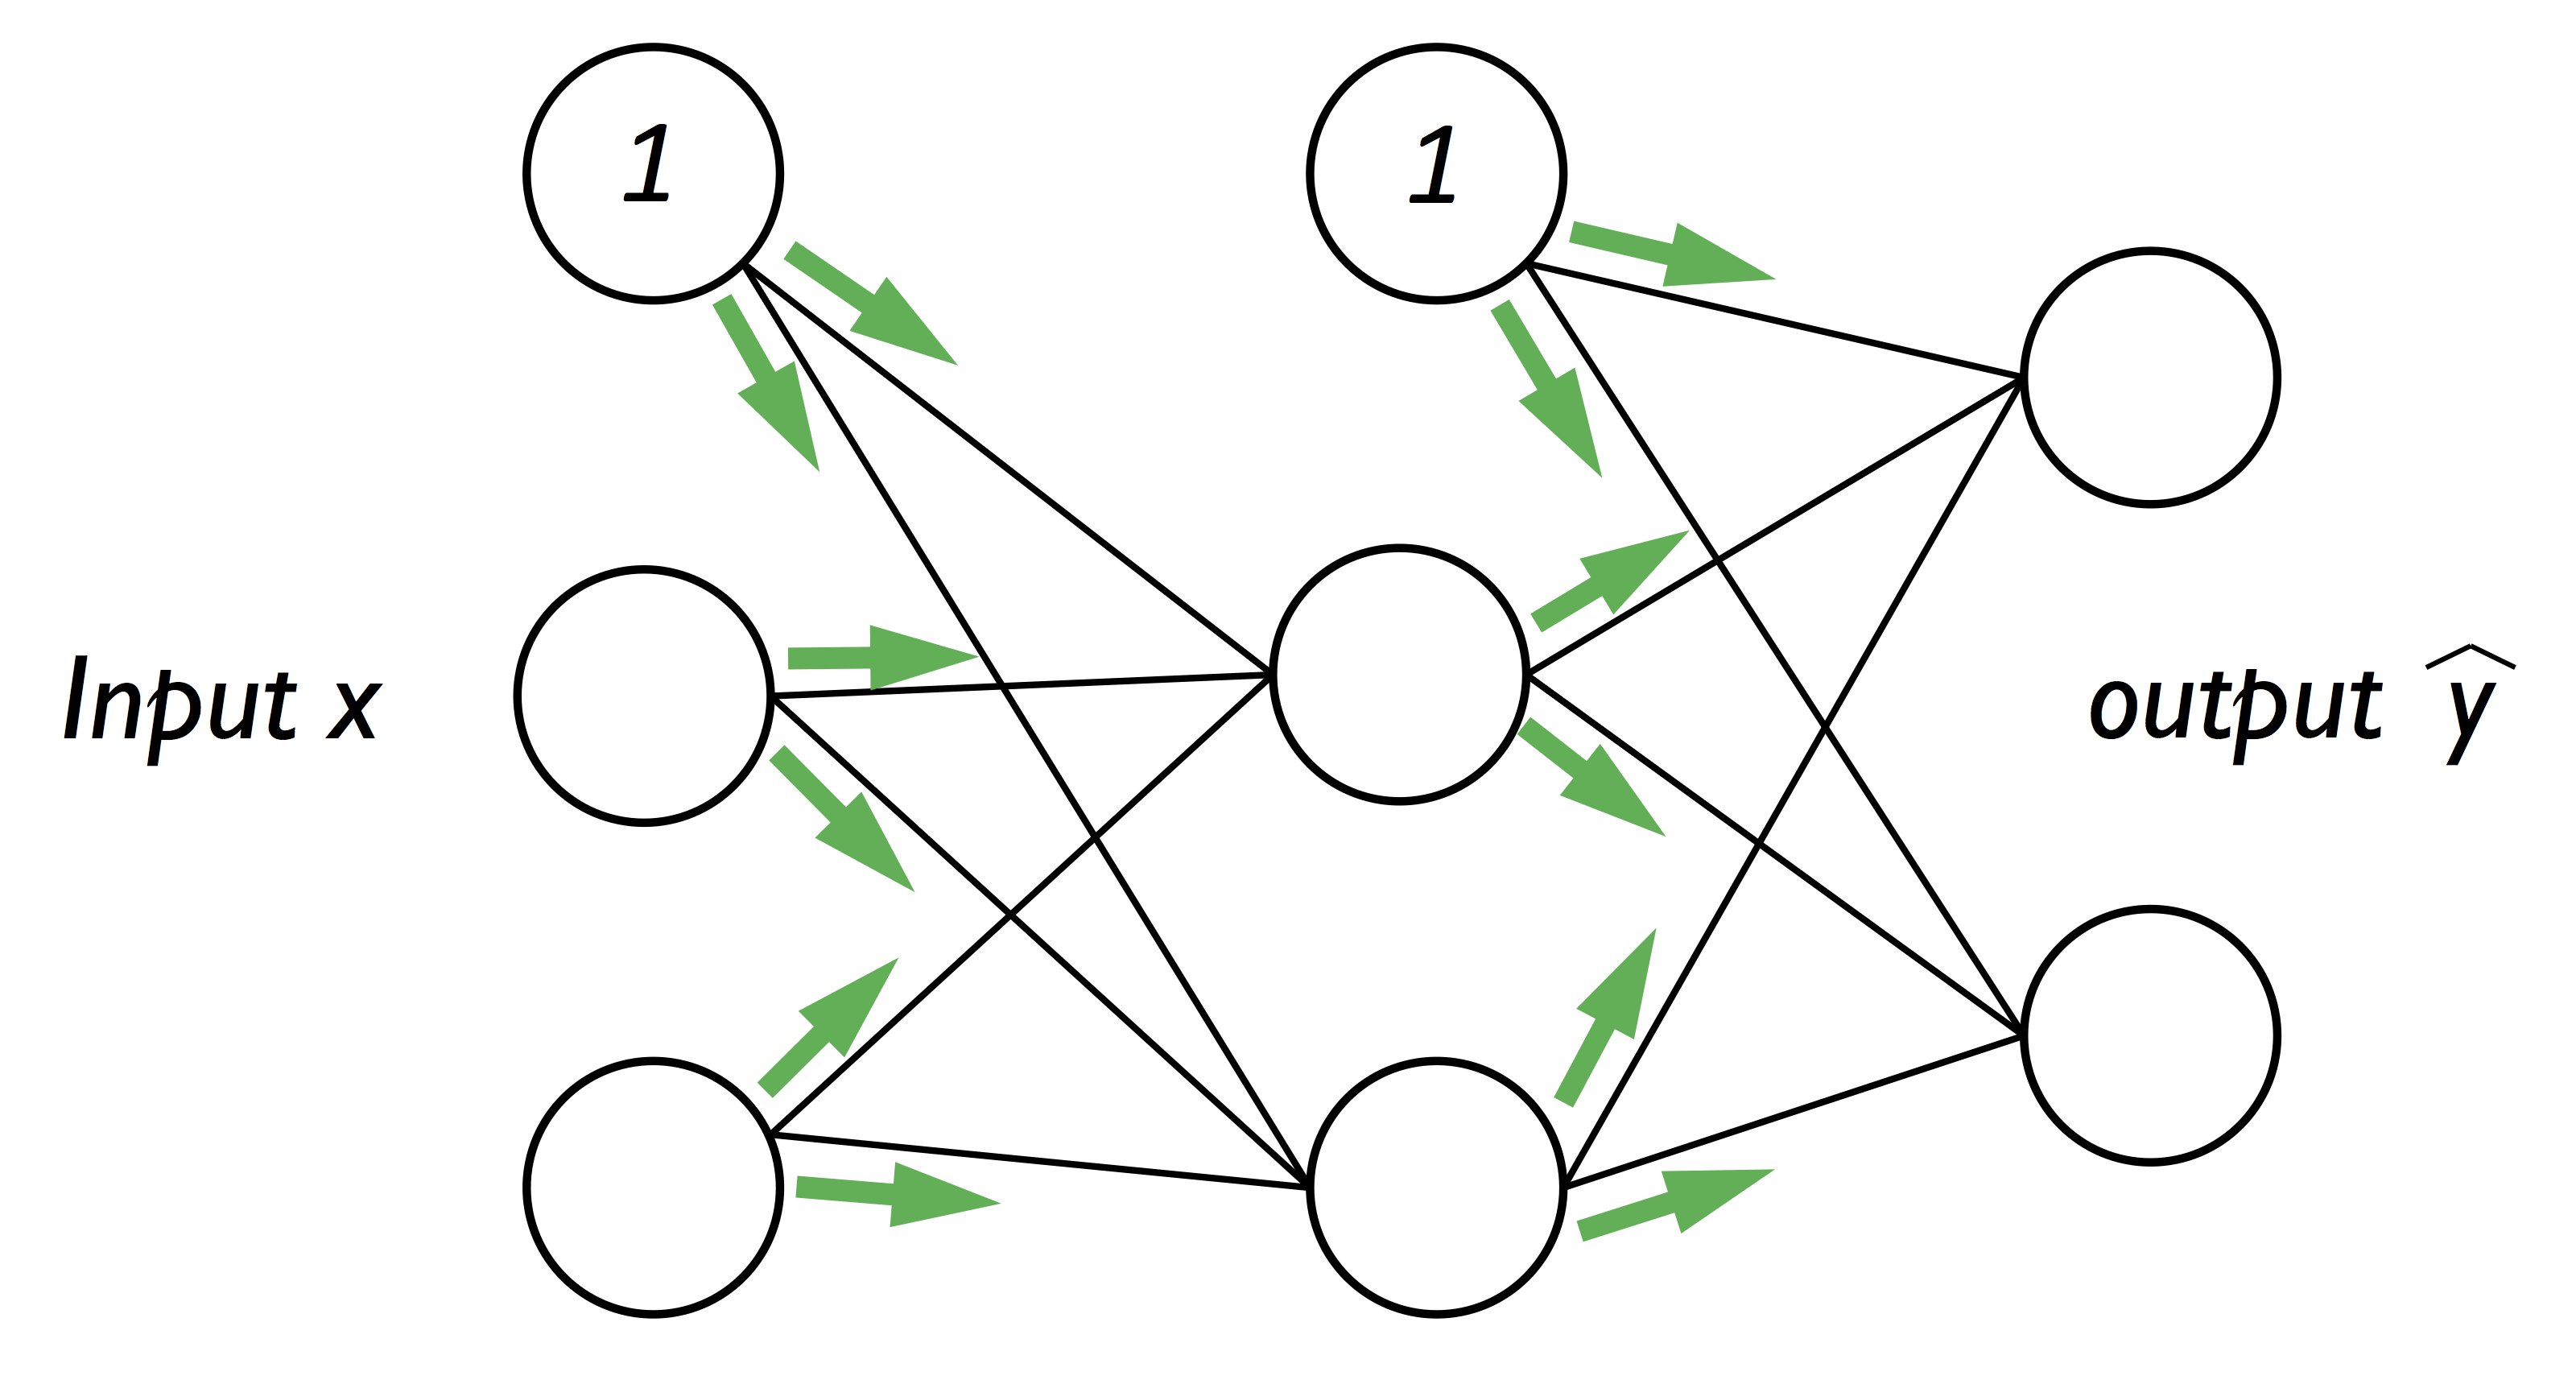%0A" height="50%" width="50%">

역전파 계산 방법
- 출력층의 오차 벡터 계산
- 은닉층의 오차항 계산
- 은닉층의 오차행렬 계산
- 이후 각 층에 있는 모든 노드의 편도 함수와 다음 층의 노드 오차를 모음
- 편도 함수를 누적한 후 규제 항을 추가
- 그래디언트를 계산하고 각 층 $l$에 대한 그래디언트의 반대 방향으로 가중치를 업데이트


<역전파 법에서 주의할 점>
1. 올바른 탐색동간 결정
2. 가중치 변화량의 결정에 유의
3. 최적해가 극소치로 빠지는 위험을 없애기 위해 다양한 초기치 고려
4. 계산시간을 고려한 신경회로망 구조를 신중히 결정

역전파 알고리즘
<img src="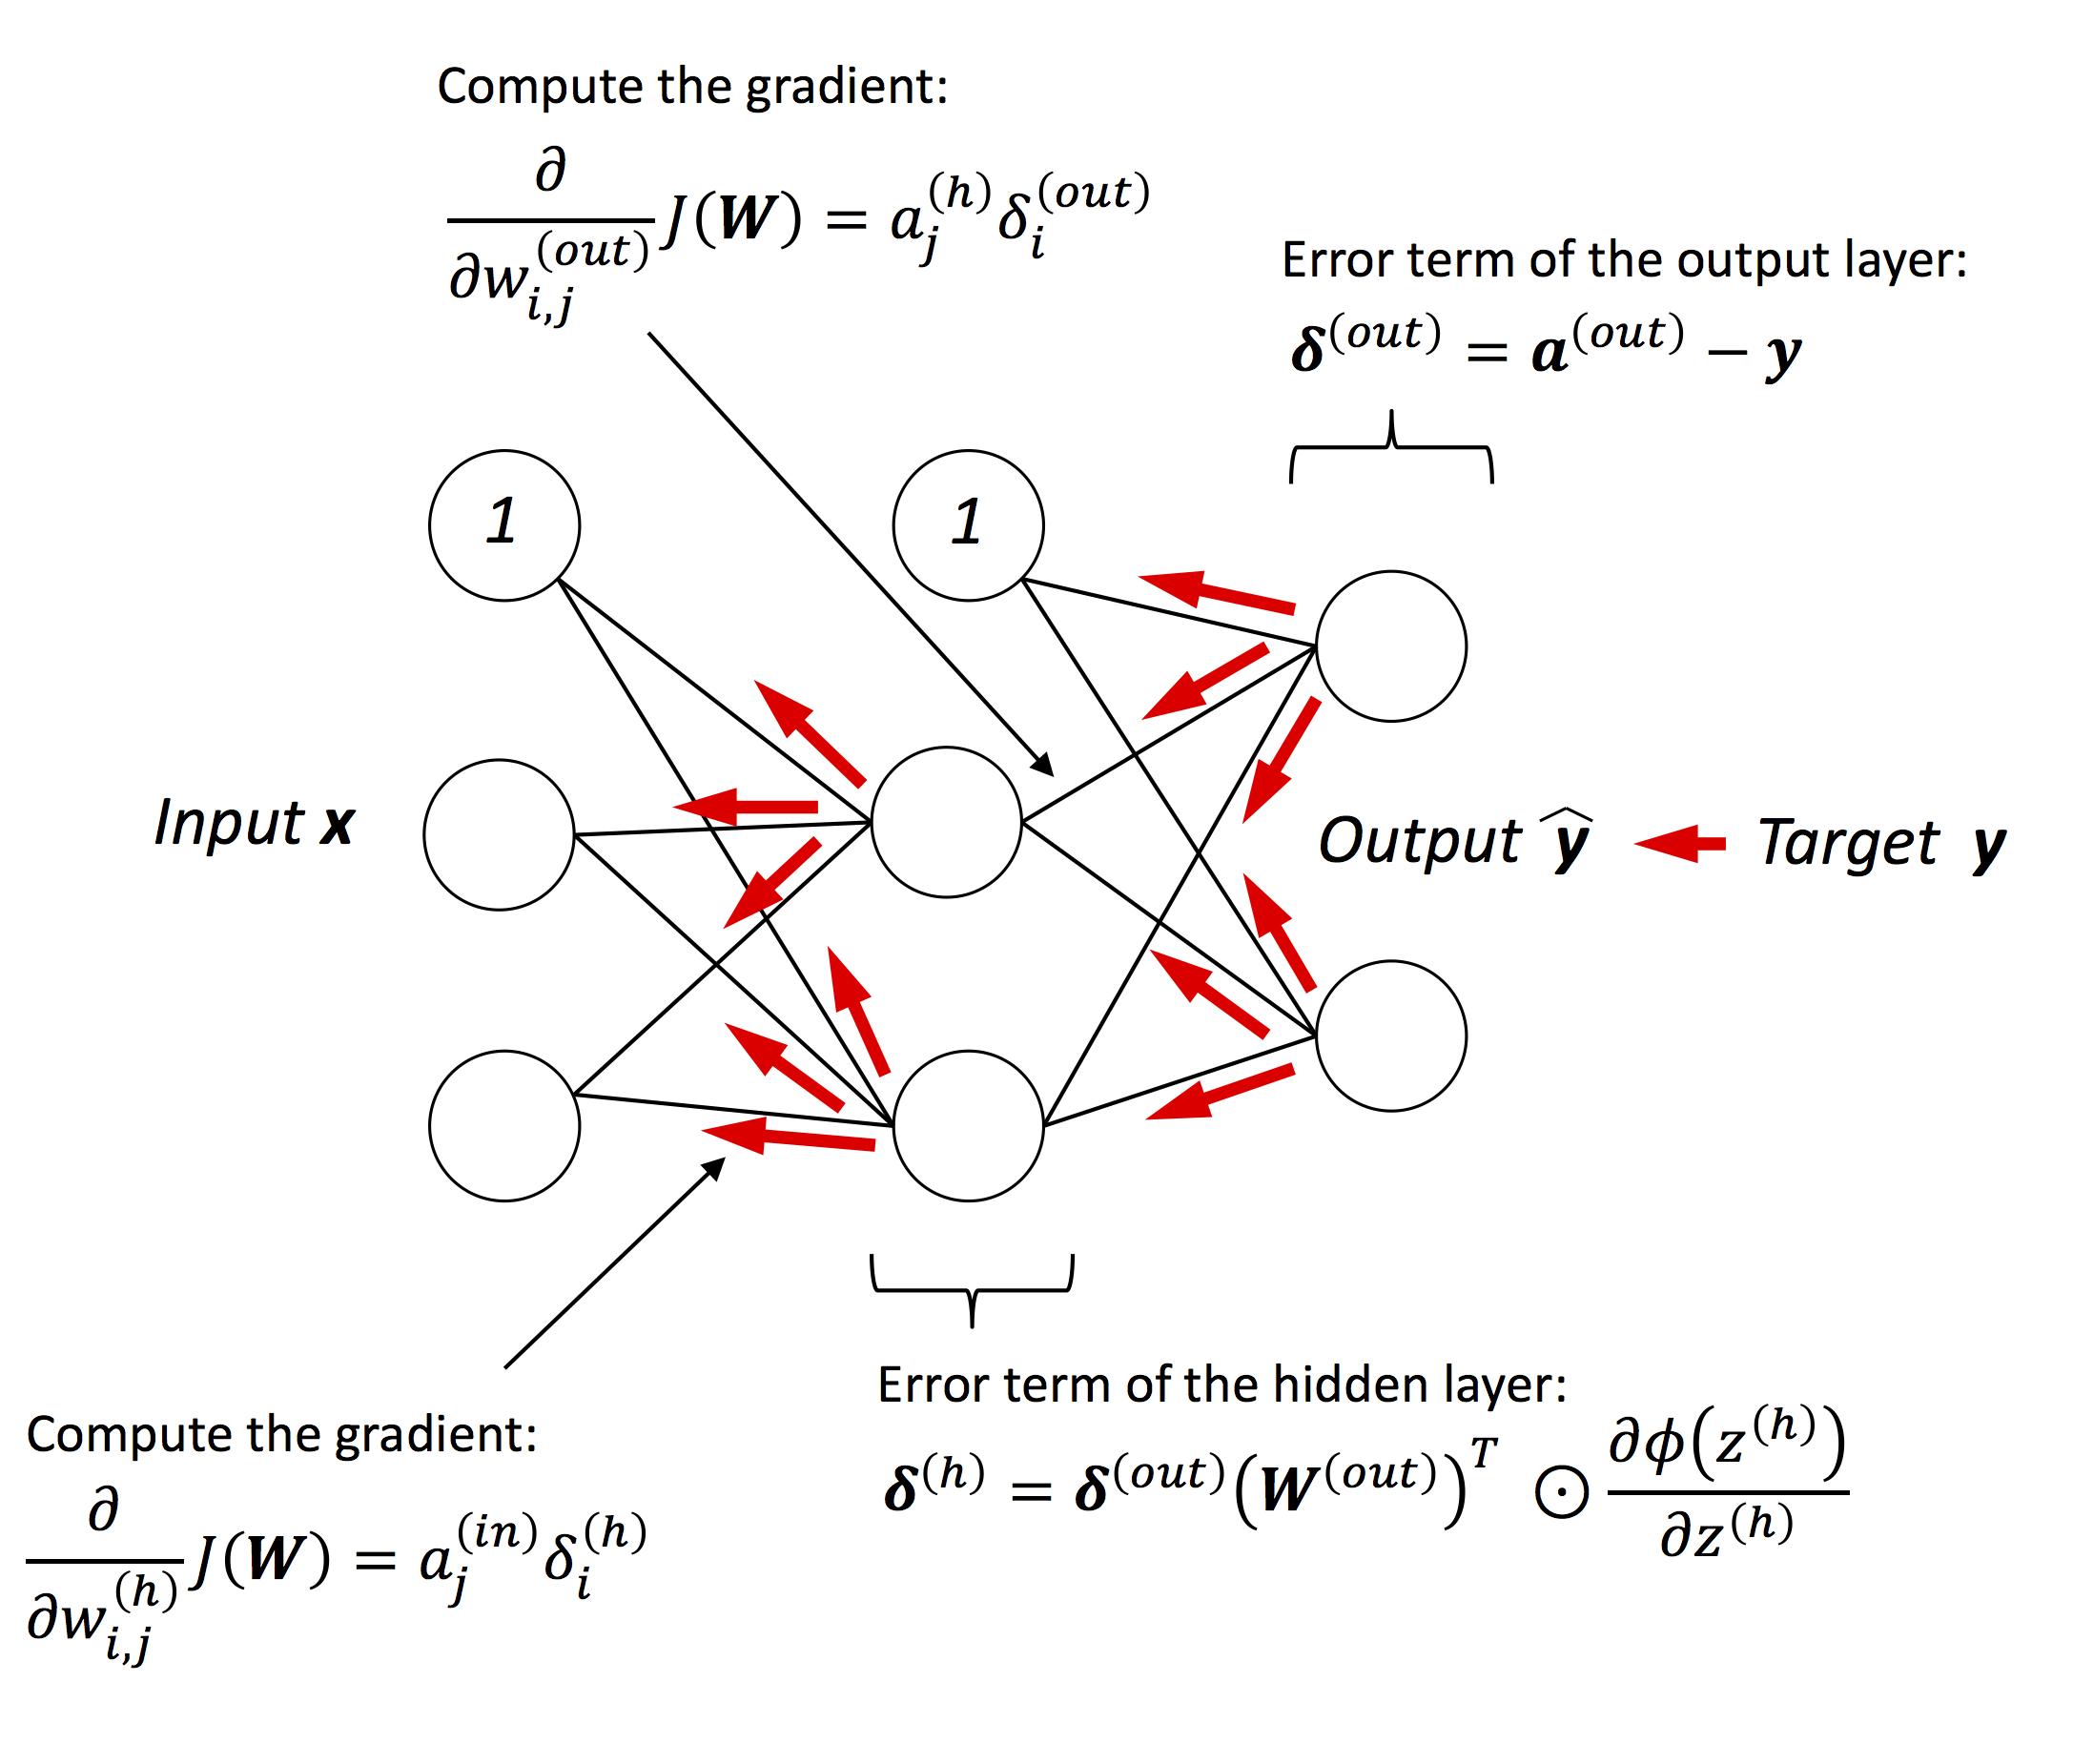%0A" height="70%" width="70%">

## 12.4 신경망의 수렴
- 미니 배치 학습 : 확률적 경사 하강법의 특별한 경우로 n개의 훈련 샘플 중 k개의 부분 집합에서 그래디언트를 계산
    - 장점 : 벡터화된 구현을 만들어 계산 효율성을 높일 수 있다. 기본 경사 하강법보다 훨씬 빠르게 가중치가 업데이트 된다.

지역 최솟값과 전역 최솟값<img src="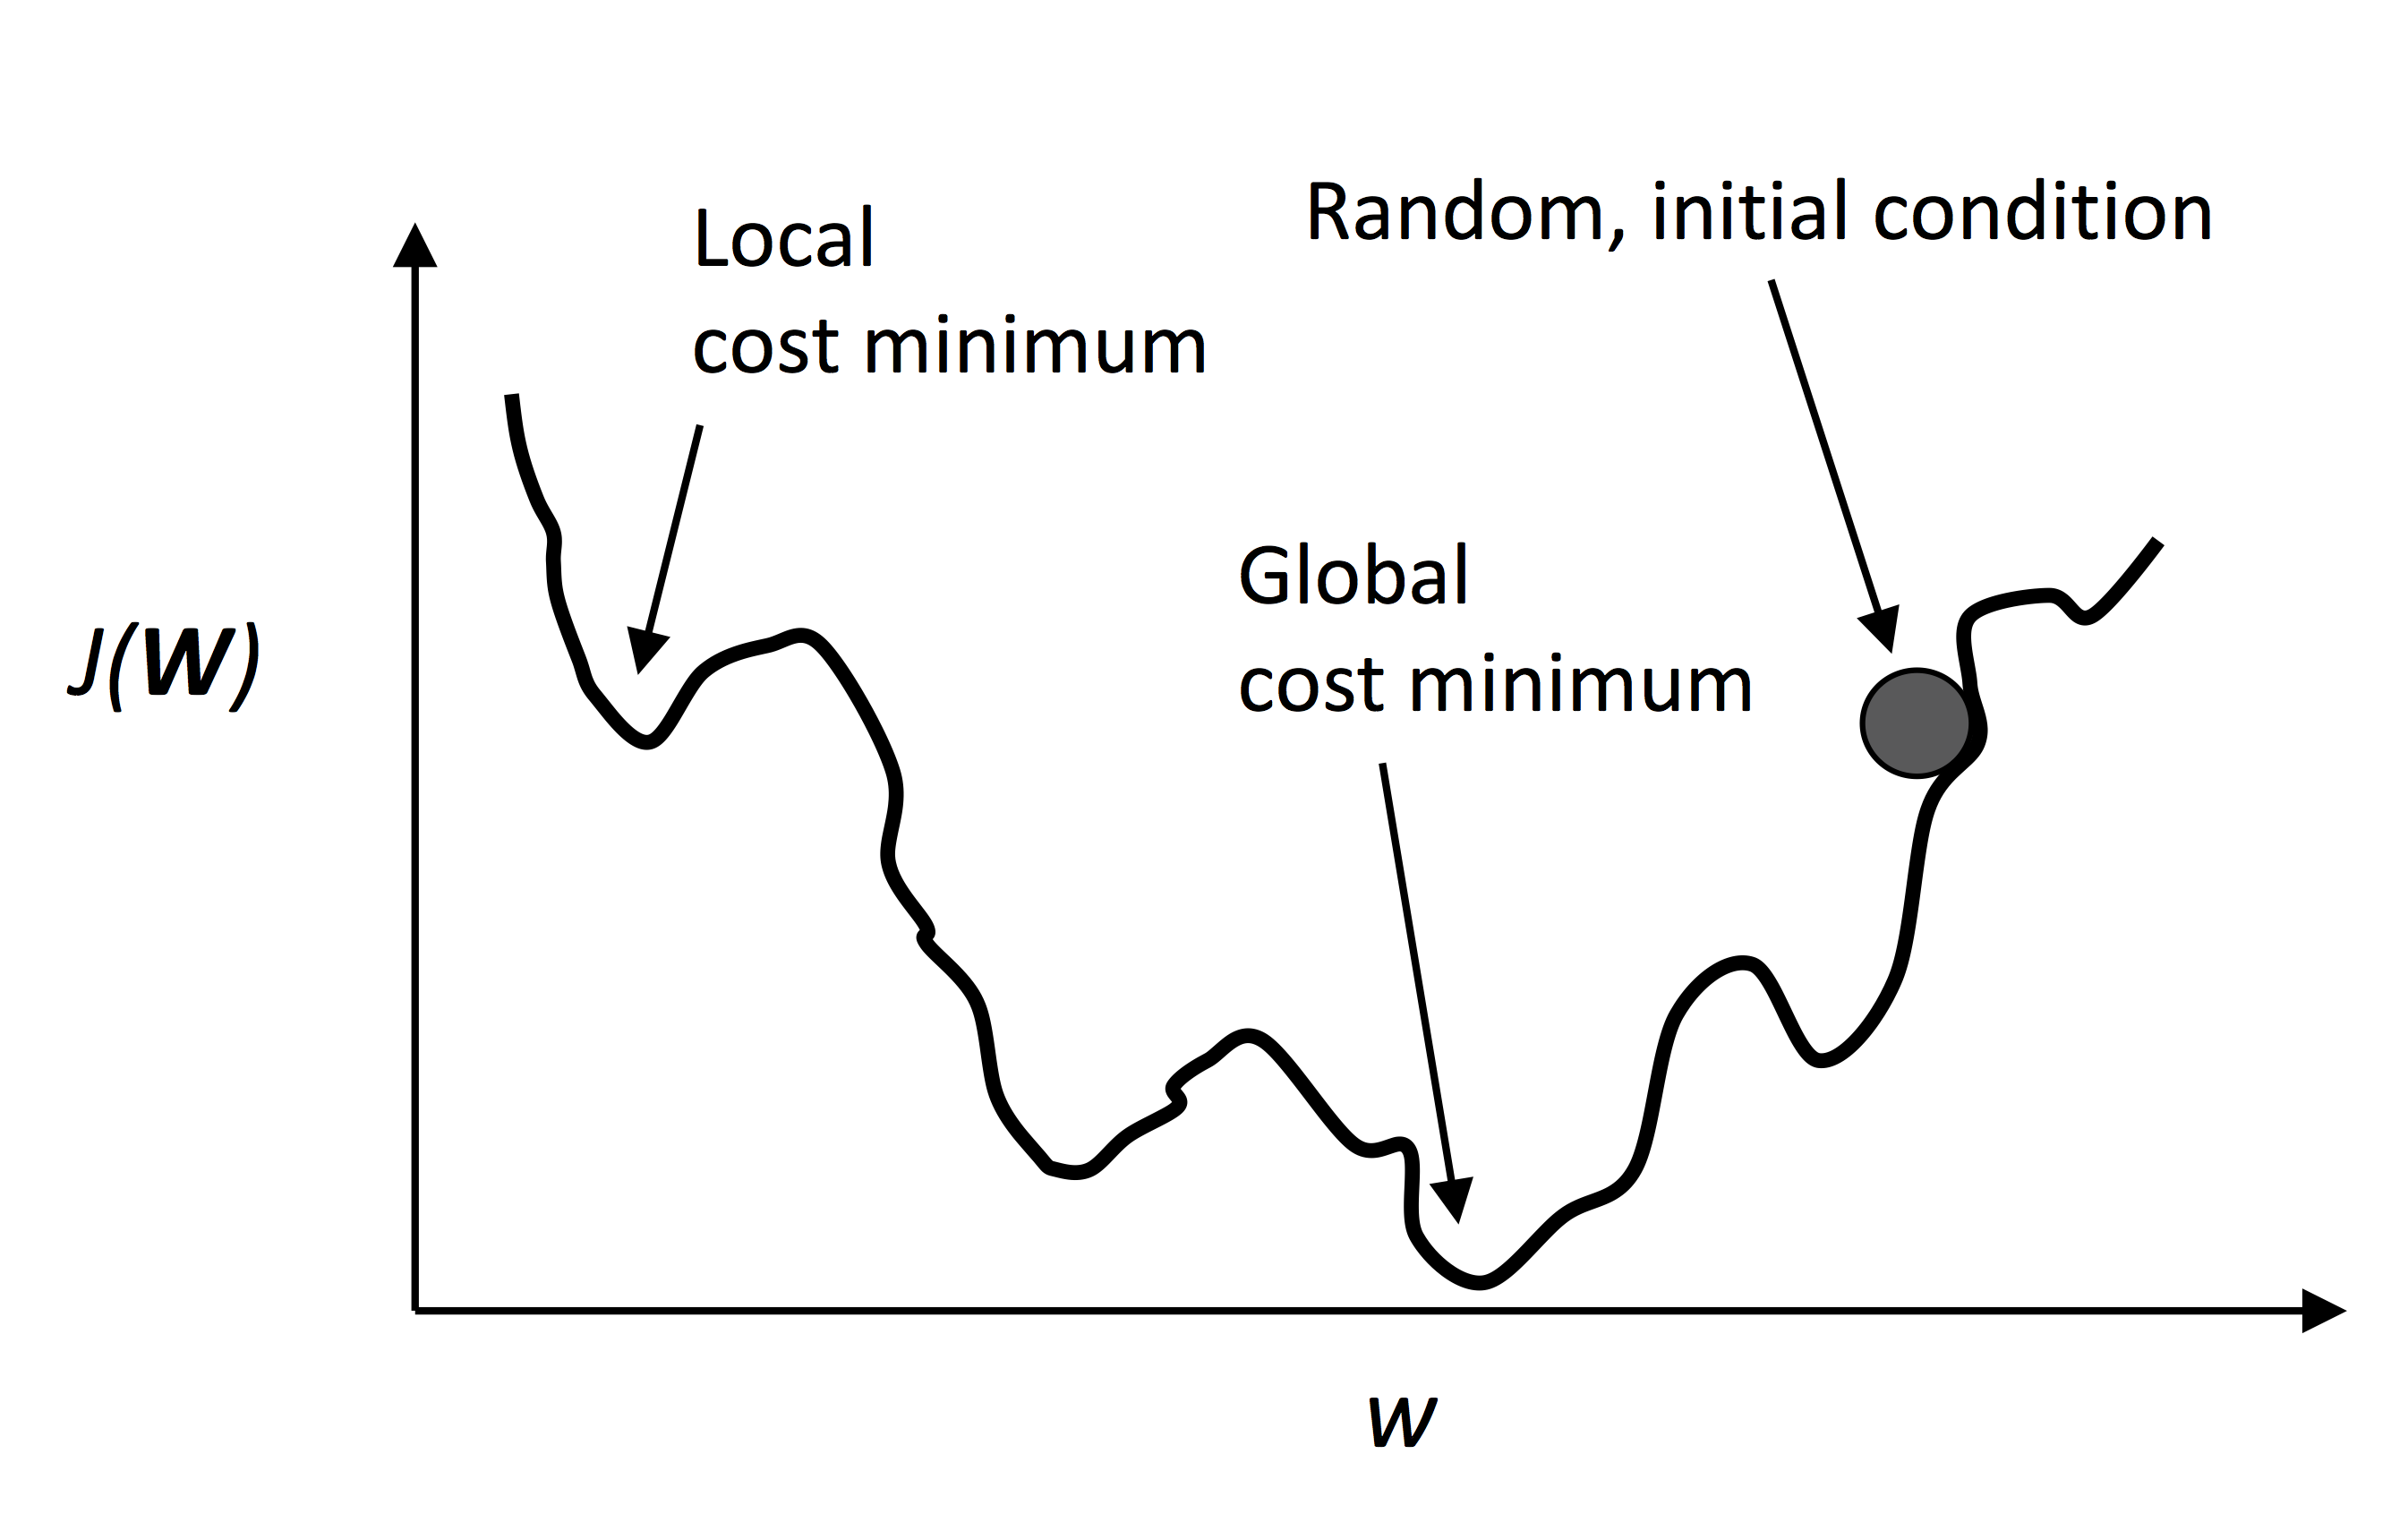%0A" height="50%" width="50%">

- 다층 신경망은 최적화해야 할 가중치가 매우 많지만 솔실 함수의 표면이 거칠어 최적화 알고리즘이 지역 최솟값에 갇힐수 있다.
- 이를 위해 학습률을 크게 하여 지역 최솟값을 탈출할 수도 있다.
- 하지만 학습률이 너무 크면 전역 최솟값을 지나칠 수 있는 가능성이 커진다.

## 12.5 신경망 구현에 관한 몇 가지 첨언

고급 심층 신경망
- 텐서플러 (저수준 딥러닝 라이브러리)
- 케라스 (널리 사용되는 딥러닝 라이브러리)